In [79]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (sec)')
    plt.grid()
    plt.plot(time_sec[:n_samples],in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples],out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()

Number of samples:  2499


<IPython.core.display.Javascript object>


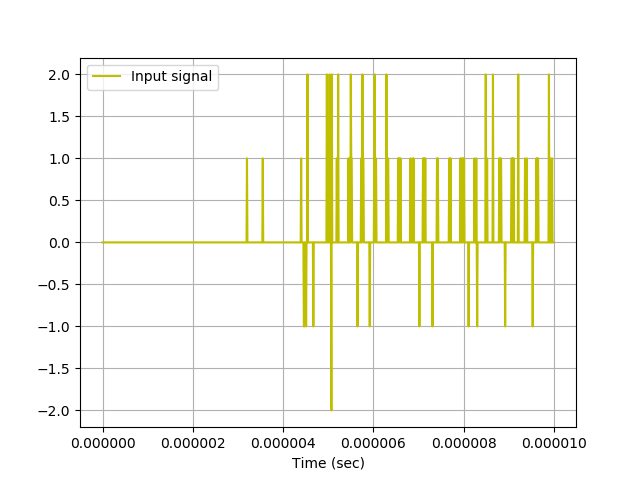

In [80]:
import numpy as np

# Total time
T = 0.002
# Sampling frequency
fs = 100e6
# Number of samples
n = int(T * fs)
# Time vector in seconds
t = np.linspace(0, T, n, endpoint=False)

df = pd.read_csv('정상.csv')
samples = df['close']
# Samples of the signal

# Convert samples to 32-bit integers
samples = samples.astype(np.int32)
print('Number of samples: ',len(samples))

# Plot signal to the notebook
plot_to_notebook(t,samples,1000)


Software FIR execution time:  0.005096912384033203


<IPython.core.display.Javascript object>


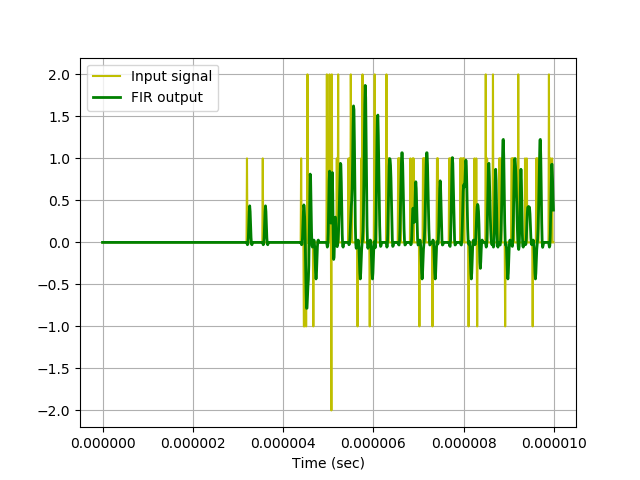

In [81]:
from scipy.signal import lfilter

coeffs = [-784,-1962,-1379,4011,14553,25663,30471,25663,14553,4011,-1379,-1962,-784]
import time
start_time = time.time()
sw_fir_output = lfilter(coeffs,70e3,samples)
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ',sw_exec_time)

# Plot the result to notebook
plot_to_notebook(t,samples,1000,out_signal=sw_fir_output)

In [82]:
from pynq import Overlay
import pynq.lib.dma

# Load the overlay
overlay = Overlay('FIR.bit')

# Load the FIR DMA
dma = overlay.filter.axi_dma_0

/usr/local/lib/python3.6/dist-packages/pynq/overlay.py:299: UserWarning: Users will not get PARAMETERS / REGISTERS information through TCL files. HWH file is recommended.
  warnings.warn(message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pynq/lib/dma.py:200: UserWarning: Failed to find parameter c_sg_length_width; users should really use *.hwh files for overlays.
  warnings.warn(message, UserWarning)


Hardware FIR execution time:  0.0020248889923095703
Hardware acceleration factor:  2.517131755563405


<IPython.core.display.Javascript object>


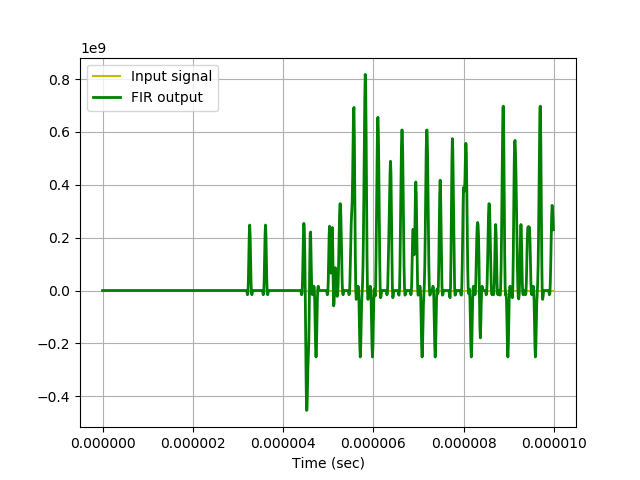

In [83]:
from pynq import Xlnk
import numpy as np

# Allocate buffers for the input and output signals
xlnk = Xlnk()
in_buffer = xlnk.cma_array(shape=(2499,), dtype=np.float32)
out_buffer = xlnk.cma_array(shape=(2499,), dtype=np.int32)

# Copy the samples to the in_buffer
np.copyto(in_buffer,samples)

# Trigger the DMA transfer and wait for the result
import time
start_time = time.time()
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time
print('Hardware FIR execution time: ',hw_exec_time)
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)

# Plot to the notebook
plot_to_notebook(t,samples,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()

In [ ]:
sw_fir_output = lfilter(coeffs,70e3,samples)

In [ ]:
test_score_df = pd.DataFrame(sw_fir_output, columns =['close'])
test_score_df.to_csv('FIR정상.csv')